<a href="https://colab.research.google.com/github/profsuccodifrutta/Variational_Autoencoder_for_Anomaly_Detection/blob/main/6_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Crea una cartella locale su Colab per i dati (veloce)
!mkdir -p /content/dataset_local

# Scompatta il file.
path_zip = "/content/drive/MyDrive/brainmri.zip"
!unzip -o -q "{path_zip}" -d /content/dataset_local
print("Scompattamento completato!")

Scompattamento completato!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import glob
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

file_sani = glob.glob("/content/dataset_local/**/Training/notumor/*.jpg", recursive=True)
print(f"--- ANALISI DATASET ---")
print(f"Totale immagini sane trovate: {len(file_sani)}")

class BrainDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('L') # Scala di grigi
        if self.transform:
            image = self.transform(image)
        return image

# 70% Train, 20% Val, 10% Test
if len(file_sani) > 0:
    full_healthy_ds = BrainDataset(file_sani)

    train_size = int(0.7 * len(full_healthy_ds))
    val_size = int(0.2 * len(full_healthy_ds))
    test_size = len(full_healthy_ds) - train_size - val_size

    train_subset, val_subset, test_healthy_subset = random_split(
        full_healthy_ds, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Recupero anomalie per il Test finale
    file_anomalie = glob.glob("/content/dataset_local/**/Testing/*/*.jpg", recursive=True)
    file_anomalie = [f for f in file_anomalie if "notumor" not in f]

    print(f"Training: {len(train_subset)} | Val: {len(val_subset)} | Test Sani: {len(test_healthy_subset)}")
    print(f"Anomalie trovate per test: {len(file_anomalie)}")
else:
    print("ERRORE: Dataset non trovato.")

--- ANALISI DATASET ---
Totale immagini sane trovate: 1595
Training: 1116 | Val: 319 | Test Sani: 160
Anomalie trovate per test: 906


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


batch_size = 32

train_loader = DataLoader(
    BrainDataset([train_subset.dataset.file_list[i] for i in train_subset.indices], transform=train_transform),
    batch_size=batch_size, shuffle=True)

val_loader = DataLoader(
    BrainDataset([val_subset.dataset.file_list[i] for i in val_subset.indices], transform=base_transform),
    batch_size=batch_size, shuffle=False)

# Test loaders
test_loader_sani = DataLoader(
    BrainDataset([test_healthy_subset.dataset.file_list[i] for i in test_healthy_subset.indices], transform=base_transform),
    batch_size=batch_size, shuffle=False)

anno_loader = DataLoader(
    BrainDataset(file_anomalie, transform=base_transform),
    batch_size=batch_size, shuffle=False)

print(f" Configurazione completata. Batch size: {batch_size}")

 Configurazione completata. Batch size: 32


In [7]:
import torch
import torch.nn as nn


import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.relu(x + self.conv(x))

class VAE_V6(nn.Module):
    def __init__(self, latent_dim=2048):
        super(VAE_V6, self).__init__()

        # ENCODER: 224 -> 112 -> 56 -> 28 -> 14 -> 7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            ResBlock(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            ResBlock(128),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2)
        )

        self.flatten_dim = 256 * 7 * 7

        self.fc_hidden_enc = nn.Sequential(
            nn.Linear(self.flatten_dim, 4096),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        self.decoder_input = nn.Sequential(
            nn.Linear(latent_dim, 4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, self.flatten_dim),
            nn.LeakyReLU(0.2)
        )
        self.unflatten = nn.Unflatten(1, (256, 7, 7))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            ResBlock(128),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            ResBlock(64),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            if m.out_channels == 1:
                nn.init.xavier_normal_(m.weight)
            else:
                nn.init.kaiming_normal_(m.weight, a=0.2, mode='fan_out', nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        h = torch.flatten(h, start_dim=1)
        hidden = self.fc_hidden_enc(h)
        mu, logvar = self.fc_mu(hidden), self.fc_logvar(hidden)

        # Clamp per stabilità numerica
        logvar = torch.clamp(logvar, -10, 10)

        z = self.reparameterize(mu, logvar)
        dec_hid = self.decoder_input(z)
        x_recon = self.decoder(self.unflatten(dec_hid))
        return x_recon, mu, logvar

In [8]:
import torch
import torch.nn.functional as F

def ssim_loss(img1, img2, window_size=11):
    mu1 = F.avg_pool2d(img1, window_size, stride=1, padding=window_size//2)
    mu2 = F.avg_pool2d(img2, window_size, stride=1, padding=window_size//2)

    sigma1_sq = F.avg_pool2d(img1 * img1, window_size, stride=1, padding=window_size//2) - mu1.pow(2)
    sigma2_sq = F.avg_pool2d(img2 * img2, window_size, stride=1, padding=window_size//2) - mu2.pow(2)

    sigma1_sq = torch.clamp(sigma1_sq, min=0)
    sigma2_sq = torch.clamp(sigma2_sq, min=0)

    sigma12 = F.avg_pool2d(img1 * img2, window_size, stride=1, padding=window_size//2) - (mu1 * mu2)

    c1, c2 = 0.01**2, 0.03**2

    num = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)
    den = (mu1.pow(2) + mu2.pow(2) + c1) * (sigma1_sq + sigma2_sq + c2)

    return 1 - (num / (den + 1e-7)).mean()

def loss_function(recon_x, x, mu, logvar, beta=0.01):
    mask = (x > 0.05).float()
    recon_x = torch.clamp(recon_x, min=1e-7, max=1-1e-7)
    bce_per_pixel = F.binary_cross_entropy(recon_x, x, reduction='none')
    masked_bce = (bce_per_pixel * mask).sum() / (mask.sum() + 1e-8)
    ssim = ssim_loss(recon_x, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = masked_bce + (5 * ssim) + (beta * kl)
    return total_loss, masked_bce, kl

In [ ]:
import torch.optim as optim

latent_dim = 2048
model = VAE_V6(latent_dim=latent_dim).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5) # lr cauto

# Scheduler: Riduce il LR del 50% (factor=0.5) se la Val Loss non migliora per 5 epoche
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


In [ ]:
def plot_reconstruction(model, val_loader, device, epoch):
    model.eval()
    with torch.no_grad():
        # batch dal loader di validazione
        inputs = next(iter(val_loader))
        inputs = inputs.to(device)

        # Ricostruzione
        recons, mu, logvar = model(inputs)

        # su cpu per plottare
        img = inputs[0].cpu().squeeze().numpy()
        recon = recons[0].cpu().squeeze().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Originale")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(recon, cmap='gray')
        plt.title(f"Ricostruzione Epoca {epoch+1}")
        plt.axis('off')

        plt.show()

In [ ]:
import numpy as np

# training loop

def train_vae(model, train_loader, val_loader, optimizer, scheduler, num_epochs):
    train_history = {'total': [], 'recon': [], 'kl': []}
    val_history = {'total': [], 'recon': [], 'kl': []}

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()

        current_beta = min(target_beta, target_beta * (epoch / warmup_epochs))

        train_total, train_recon, train_kl = 0, 0, 0

        for batch in train_loader:
            batch = batch.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)

            loss, r_loss, k_loss = loss_function(recon_batch, batch, mu, logvar, beta=current_beta)

            if torch.isnan(loss):
                print(f" Batch saltato all'epoca {epoch+1}: rilevato NaN nella loss")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_total += loss.item()
            train_recon += r_loss.item()
            train_kl += k_loss.item()

        # VALIDAZIONE
        model.eval()
        val_total, val_recon, val_kl = 0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon_batch, mu, logvar = model(batch)
                loss, r_loss, k_loss = loss_function(recon_batch, batch, mu, logvar, beta=current_beta)

                val_total += loss.item()
                val_recon += r_loss.item()
                val_kl += k_loss.item()

        # Calcolo medie per epoca
        avg_train_loss = train_total / len(train_loader)
        avg_val_loss = val_total / len(val_loader)

        scheduler.step(avg_val_loss)

        # Salvataggio storia
        train_history['total'].append(avg_train_loss)
        val_history['total'].append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Beta: {current_beta:.5f} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/VAE_Brain_Project/best_model_v6.pth')
            print(" Miglior modello salvato!")


        if (epoch + 1) % 5 == 0:
            print(f"\n--- Visualizzazione Ricostruzione (Epoca {epoch+1}) ---")
            plot_reconstruction(model, val_loader, device, epoch)

            plt.figure(figsize=(8, 4))
            plt.plot(train_history['total'], label='Train Loss')
            plt.plot(val_history['total'], label='Val Loss')
            plt.title(f"Andamento Loss fino a Epoca {epoch+1}")
            plt.legend()
            plt.show()

    return train_history, val_history

In [ ]:
# TRAINING
num_epochs = 80
target_beta = 0.005
warmup_epochs = 20

history_train, history_val = train_vae(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs
)

In [9]:
# CARICAMENTO MODELLO
from google.colab import drive
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 2048
model = VAE_V6(latent_dim=latent_dim).to(device)

model_path_v6 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v6.pth"

try:
    checkpoint = torch.load(model_path_v6, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()
    print(f" Modello V6 caricato correttamente!")
    total_params = sum(p.numel() for p in model.parameters())
    print(f" Capacità: {total_params:,} parametri.")


except FileNotFoundError:
    print(f" Errore: Il file '{model_path_v6}' non esiste.")
except RuntimeError as e:
    print(f" Errore di architettura: Incompatibilità rilevata.")

 Modello V6 caricato correttamente!
 Capacità: 130,647,937 parametri.


In [10]:
# logica per la classificazione
import torch
import torch.nn as nn
import numpy as np

def get_anomaly_scores(model, dataloader, device):
    model.eval()
    mse_loss = nn.MSELoss(reduction='none')

    anomaly_scores = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            recon, _, _ = model(images)
            error_per_pixel = mse_loss(recon, images)
            mask = (images > 0.05).float()
            masked_error = error_per_pixel * mask
            error_sum = masked_error.view(masked_error.size(0), -1).sum(dim=1)
            pixels_count = mask.view(mask.size(0), -1).sum(dim=1)
            batch_scores = error_sum / (pixels_count + 1e-8)
            anomaly_scores.extend(batch_scores.cpu().numpy())

    return anomaly_scores

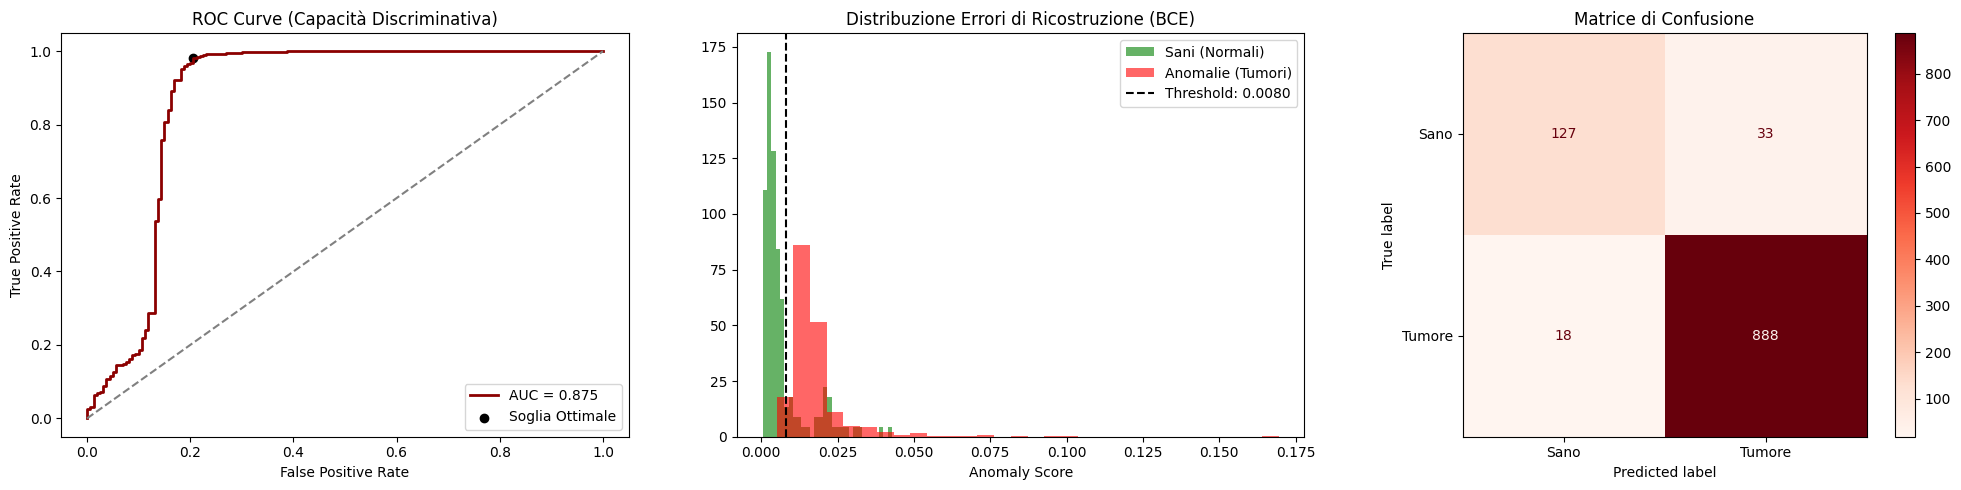


   PERFORMANCE REPORT V5
Accuracy:           0.9522
F1-Score:           0.9721
Recall (Sensibilità): 0.9801
AUC Score:          0.8749
No Information Rate: 0.8499
Soglia calcolata:    0.007980
------------------------------
              precision    recall  f1-score   support

        Sano       0.88      0.79      0.83       160
      Tumore       0.96      0.98      0.97       906

    accuracy                           0.95      1066
   macro avg       0.92      0.89      0.90      1066
weighted avg       0.95      0.95      0.95      1066



In [12]:
import numpy as np
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

test_healthy_scores = get_anomaly_scores(model, test_loader_sani, device)
test_anomaly_scores = get_anomaly_scores(model, anno_loader, device)

y_true = np.array([0] * len(test_healthy_scores) + [1] * len(test_anomaly_scores))
y_scores = np.concatenate([test_healthy_scores, test_anomaly_scores])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = [1 if s > optimal_threshold else 0 for s in y_scores]

acc_modello = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
conteggio_classi = np.bincount(y_true)
nir = np.max(conteggio_classi) / len(y_true)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# ROC Curve
ax1.plot(fpr, tpr, color='darkred', lw=2, label=f'AUC = {auc_value:.3f}')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black', label='Soglia Ottimale')
ax1.set_title('ROC Curve (Capacità Discriminativa)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")

# Istogramma Distribuzione
ax2.hist(test_healthy_scores, bins=30, alpha=0.6, label='Sani (Normali)', color='green', density=True)
ax2.hist(test_anomaly_scores, bins=30, alpha=0.6, label='Anomalie (Tumori)', color='red', density=True)
ax2.axvline(optimal_threshold, color='black', linestyle='--', label=f'Threshold: {optimal_threshold:.4f}')
ax2.set_title('Distribuzione Errori di Ricostruzione (BCE)')
ax2.set_xlabel('Anomaly Score')
ax2.legend()

# Matrice di Confusione
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sano', 'Tumore'])
disp.plot(ax=ax3, cmap='Reds', values_format='d')
ax3.set_title('Matrice di Confusione')

plt.tight_layout()
plt.show()

# report finale
print(f"\n" + "="*30)
print(f"   PERFORMANCE REPORT V5")
print(f"="*30)
print(f"Accuracy:           {acc_modello:.4f}")
print(f"F1-Score:           {f1:.4f}")
print(f"Recall (Sensibilità): {recall:.4f}")
print(f"AUC Score:          {auc_value:.4f}")
print(f"No Information Rate: {nir:.4f}")
print(f"Soglia calcolata:    {optimal_threshold:.6f}")
print("-" * 30)
print(classification_report(y_true, y_pred, target_names=['Sano', 'Tumore']))

--- ANALISI: TEST SANI ---
Risoluzione: 224x224
Range Pixel: [0.00, 1.00]


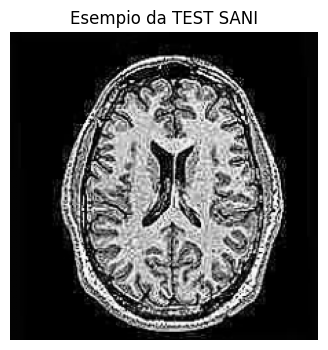

--- ANALISI: ANOMALIE (Tumori) ---
Risoluzione: 224x224
Range Pixel: [0.00, 1.00]


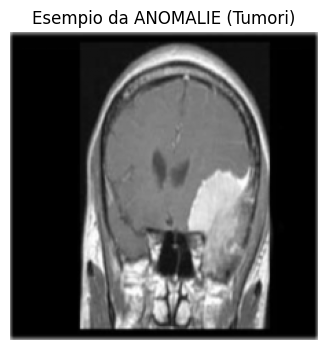

In [13]:
import matplotlib.pyplot as plt

def inspect_loader(loader, name):
    batch = next(iter(loader))
    img = batch[0].cpu().squeeze()

    print(f"--- ANALISI: {name} ---")
    print(f"Risoluzione: {batch.shape[2]}x{batch.shape[3]}")
    print(f"Range Pixel: [{batch.min().item():.2f}, {batch.max().item():.2f}]")

    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.title(f"Esempio da {name}")
    plt.axis('off')
    plt.show()

# Ispezioniamo entrambi
inspect_loader(test_loader_sani, "TEST SANI")
inspect_loader(anno_loader, "ANOMALIE (Tumori)")

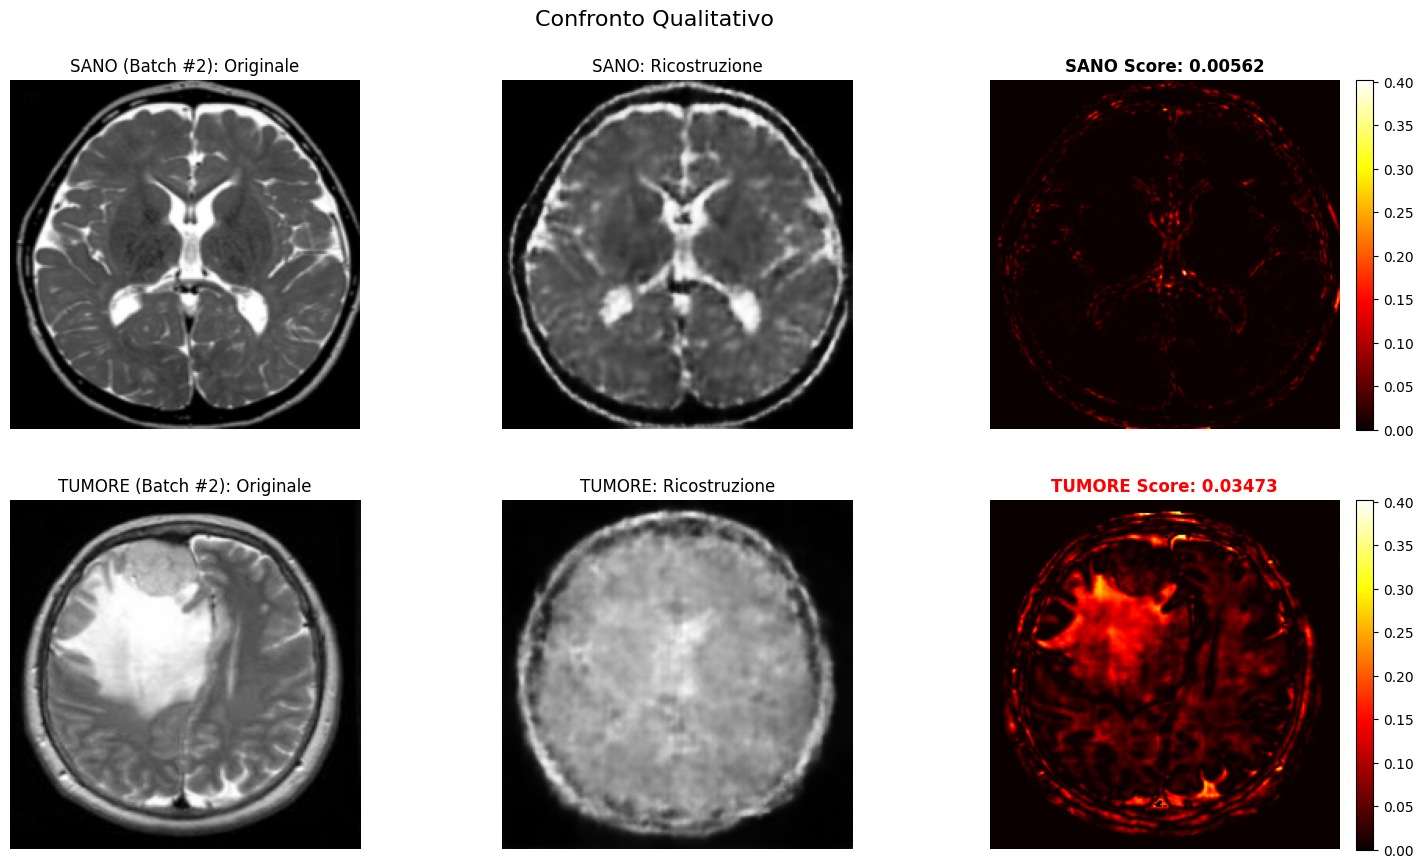

In [17]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def visualize_mri_anomaly(model, loader_sani, loader_anno, device, skip_batches=0, skip_sani=None):
    model.eval()
    mse_loss = nn.MSELoss(reduction='none')

    # Se non specifichi skip_sani, usa lo stesso valore di skip_batches
    if skip_sani is None:
        skip_sani = skip_batches

    with torch.no_grad():
        iter_sani = iter(loader_sani)
        iter_anno = iter(loader_anno)

        # Salto i batch per i SANI
        for _ in range(skip_sani):
            try:
                next(iter_sani)
            except StopIteration:
                iter_sani = iter(loader_sani)
                break

        # Salto i batch per i TUMORI
        for _ in range(skip_batches):
            try:
                next(iter_anno)
            except StopIteration:
                iter_anno = iter(loader_anno)
                break

        # Prendo l'immagine corrente
        try:
            img_sano = next(iter_sani)
        except StopIteration:
            iter_sani = iter(loader_sani)
            img_sano = next(iter_sani)

        try:
            img_anno = next(iter_anno)
        except StopIteration:
            iter_anno = iter(loader_anno)
            img_anno = next(iter_anno)

        if isinstance(img_sano, (list, tuple)): img_sano = img_sano[0]
        if isinstance(img_anno, (list, tuple)): img_anno = img_anno[0]

        img_sano = img_sano[0:1].to(device)
        img_anno = img_anno[0:1].to(device)

        rec_sano, _, _ = model(img_sano)
        rec_anno, _, _ = model(img_anno)

        mask_sano = (img_sano > 0.05).float()
        mask_anno = (img_anno > 0.05).float()

        err_sano = mse_loss(rec_sano, img_sano) * mask_sano
        err_anno = mse_loss(rec_anno, img_anno) * mask_anno

        score_sano = err_sano.sum() / (mask_sano.sum() + 1e-8)
        score_anno = err_anno.sum() / (mask_anno.sum() + 1e-8)

        err_sano = err_sano.cpu().squeeze()
        err_anno = err_anno.cpu().squeeze()

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # SANO
        axes[0,0].imshow(img_sano.cpu().squeeze(), cmap='gray')
        axes[0,0].set_title(f"SANO (Batch #{skip_sani}): Originale", fontsize=12)
        axes[0,1].imshow(rec_sano.cpu().squeeze(), cmap='gray')
        axes[0,1].set_title("SANO: Ricostruzione", fontsize=12)
        im1 = axes[0,2].imshow(err_sano, cmap='hot', vmin=0)
        axes[0,2].set_title(f"SANO Score: {score_sano:.5f}", fontsize=12, fontweight='bold')
        fig.colorbar(im1, ax=axes[0,2], fraction=0.046, pad=0.04)

        # TUMORE
        axes[1,0].imshow(img_anno.cpu().squeeze(), cmap='gray')
        axes[1,0].set_title(f"TUMORE (Batch #{skip_batches}): Originale", fontsize=12)
        axes[1,1].imshow(rec_anno.cpu().squeeze(), cmap='gray')
        axes[1,1].set_title("TUMORE: Ricostruzione", fontsize=12)

        vmax_val = max(err_anno.max(), err_sano.max())
        im2 = axes[1,2].imshow(err_anno, cmap='hot', vmin=0, vmax=vmax_val)
        axes[1,2].set_title(f"TUMORE Score: {score_anno:.5f}", fontsize=12, fontweight='bold', color='red')
        fig.colorbar(im2, ax=axes[1,2], fraction=0.046, pad=0.04)

        for ax in axes.flatten(): ax.axis('off')
        plt.suptitle(f"Confronto Qualitativo", fontsize=16, y=0.95)
        plt.show()


visualize_mri_anomaly(model, test_loader_sani, anno_loader, device, skip_batches=2, skip_sani=2)
# good visualizations: skip_batches = 3, 19,20,21,22, 27

Analisi FP con Soglia: 0.007980...
 Trovati 33 Falsi Positivi reali su 160 immagini.


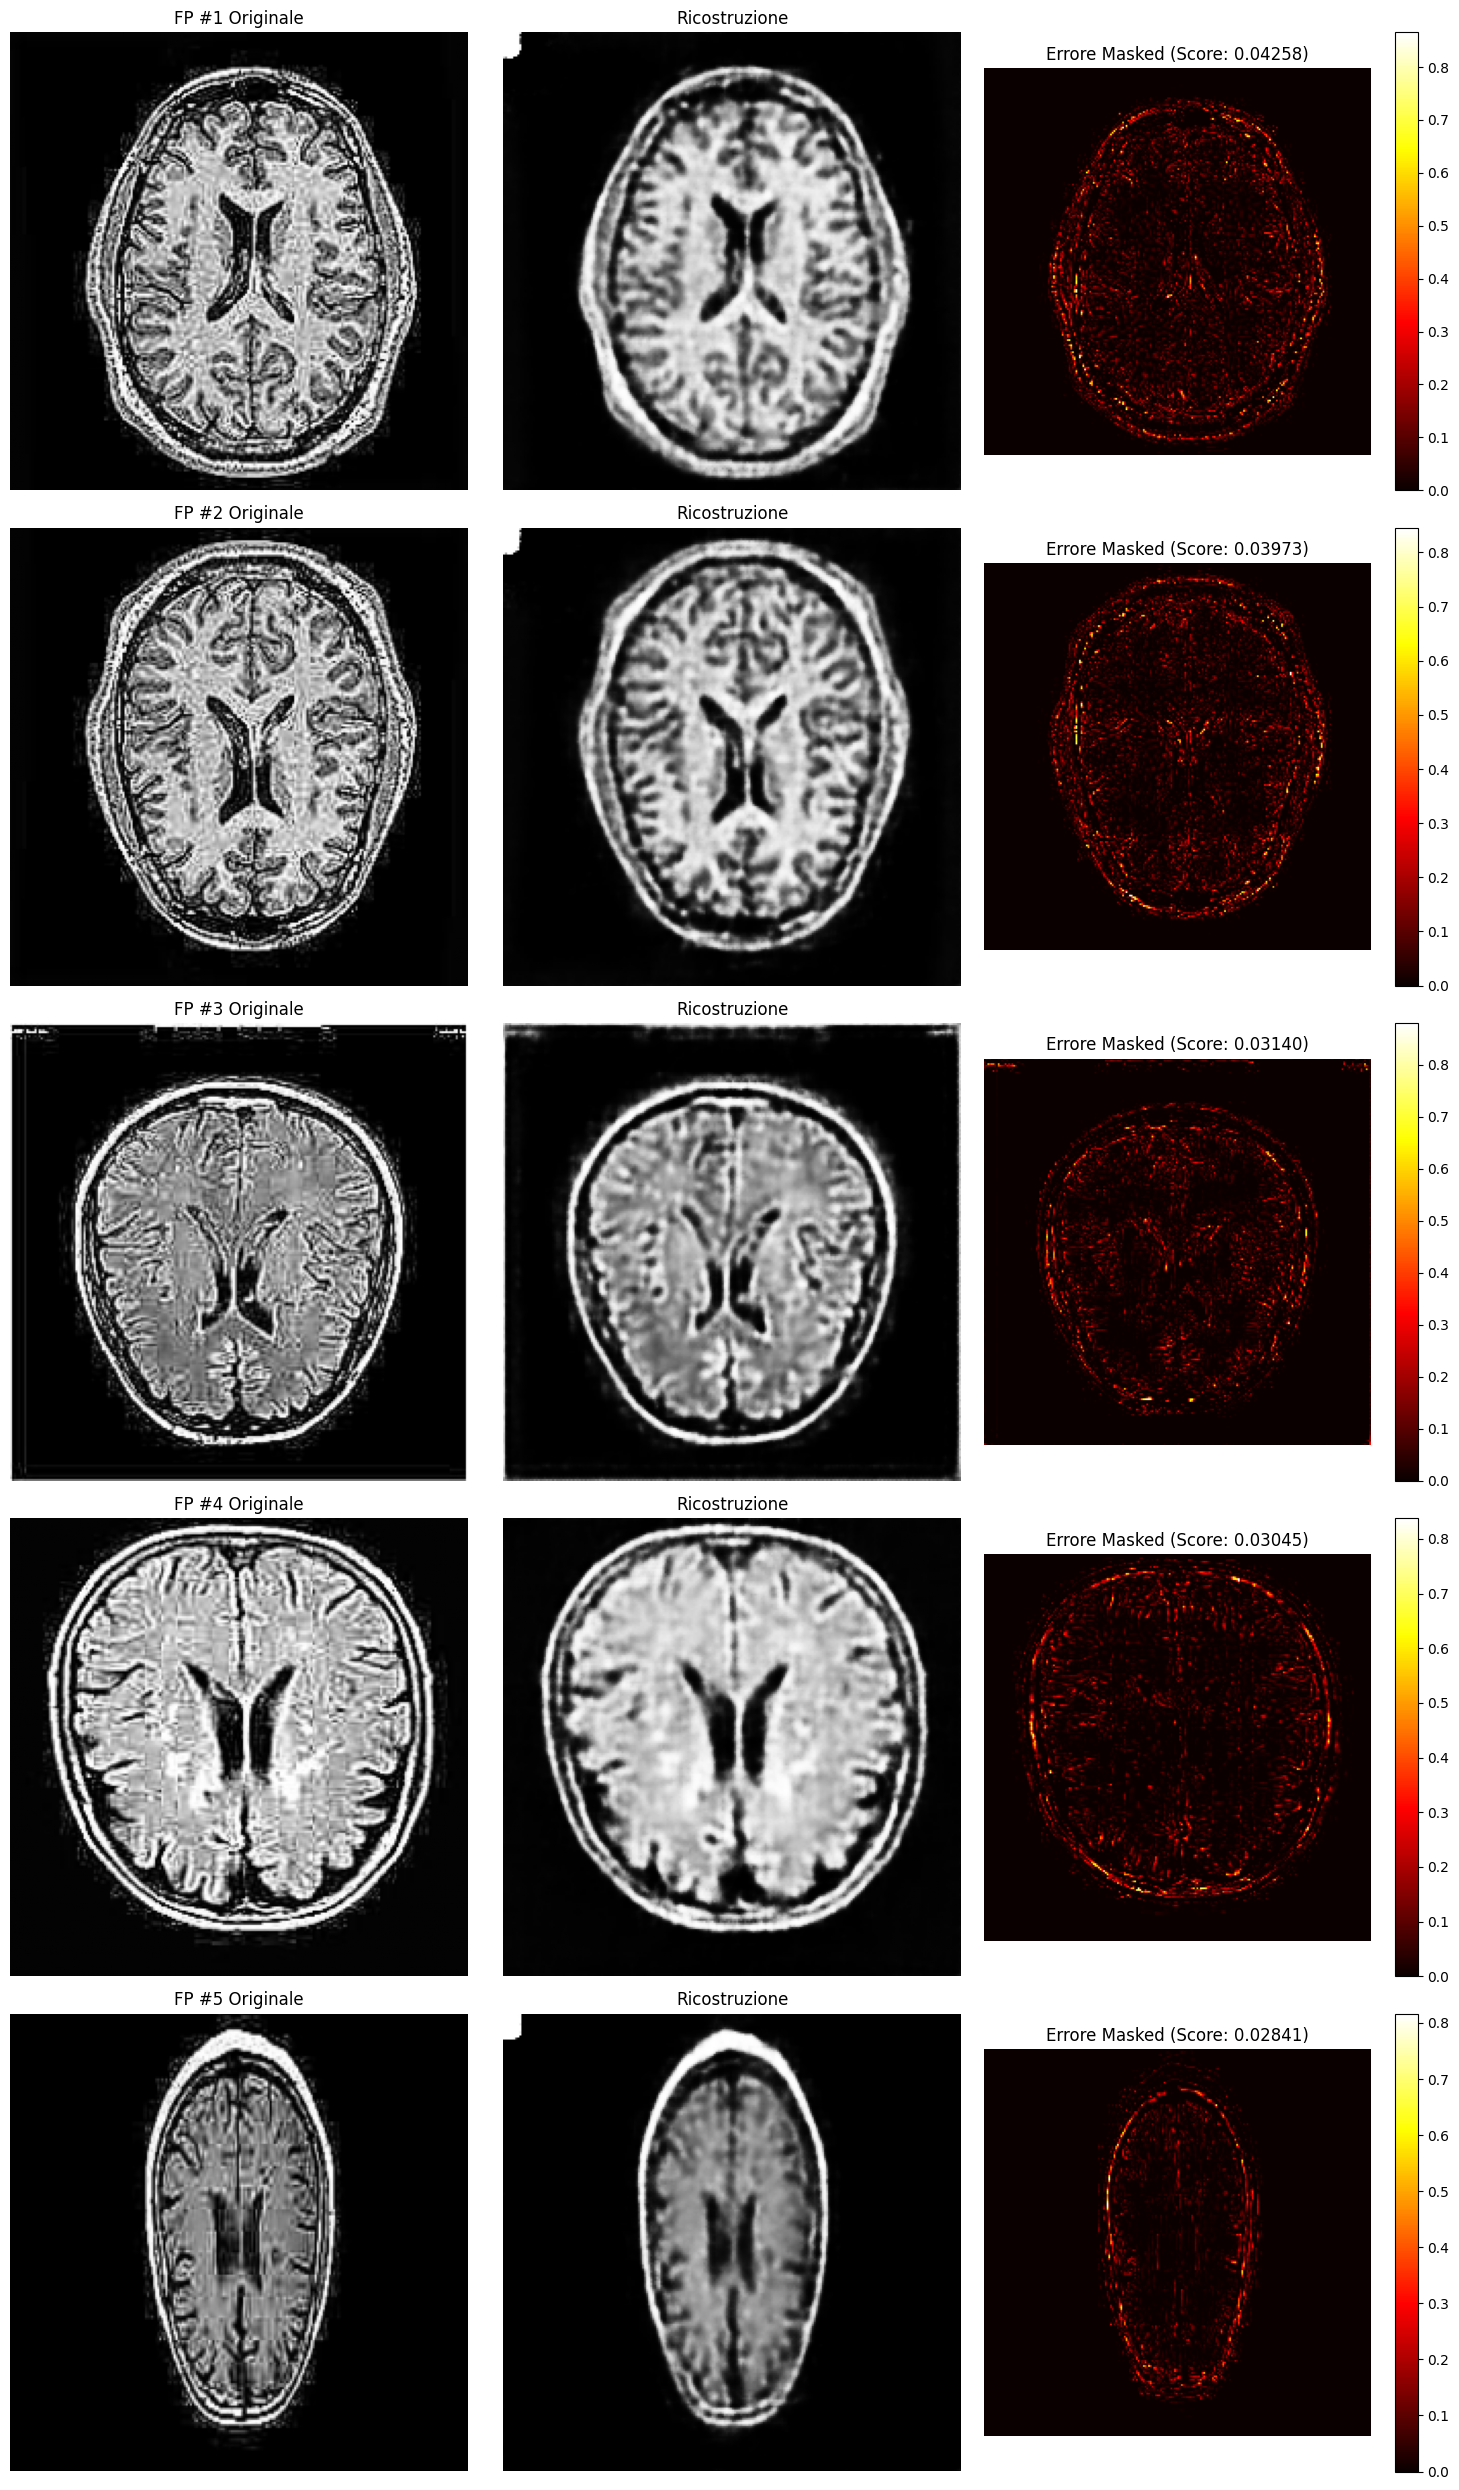

In [18]:
# identifica immagini sane che il modello ha scambiato per tumori
def analyze_false_positives(model, loader_sani, threshold, device, n_max=5):
    model.eval()
    mse_loss = nn.MSELoss(reduction='none')
    fp_list = []

    print(f"Analisi FP con Soglia: {threshold:.6f}...")

    with torch.no_grad():
        for batch in loader_sani:
            if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
            else:
                imgs = batch.to(device)

            recon, _, _ = model(imgs)

            error_per_pixel = mse_loss(recon, imgs)
            mask = (imgs > 0.05).float()
            masked_error = error_per_pixel * mask

            error_sums = masked_error.view(imgs.size(0), -1).sum(dim=1)
            pixel_counts = mask.view(imgs.size(0), -1).sum(dim=1)
            scores = error_sums / (pixel_counts + 1e-8)
            fp_indices = torch.where(scores > threshold)[0]

            for idx in fp_indices:
                fp_list.append({
                    'img': imgs[idx].cpu(),
                    'rec': recon[idx].cpu(),
                    'err': masked_error[idx].cpu(),
                    'score': scores[idx].item()
                })

    fp_list = sorted(fp_list, key=lambda x: x['score'], reverse=True)

    if not fp_list:
        print(" Ottimo! Nessun Falso Positivo trovato.")
        return

    print(f" Trovati {len(fp_list)} Falsi Positivi reali su {len(loader_sani.dataset)} immagini.")

    # Plotting
    n_plot = min(n_max, len(fp_list))
    fig, axes = plt.subplots(n_plot, 3, figsize=(15, 5 * n_plot))
    if n_plot == 1: axes = [axes] # Gestione singola riga

    for i in range(n_plot):
        img = fp_list[i]['img'].squeeze()
        rec = fp_list[i]['rec'].squeeze()
        err_map = fp_list[i]['err'].squeeze()
        score = fp_list[i]['score']

        axes[i][0].imshow(img, cmap='gray'); axes[i][0].set_title(f"FP #{i+1} Originale")
        axes[i][1].imshow(rec, cmap='gray'); axes[i][1].set_title(f"Ricostruzione")
        im = axes[i][2].imshow(err_map, cmap='hot', vmin=0); axes[i][2].set_title(f"Errore Masked (Score: {score:.5f})")
        fig.colorbar(im, ax=axes[i][2])

        for ax in axes[i]: ax.axis('off')

    plt.tight_layout()
    plt.show()

analyze_false_positives(model, test_loader_sani, optimal_threshold, device)